In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from numpy.random import default_rng

plt.rcParams["figure.constrained_layout.use"] = True

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.13.0


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = sum(map(ord, "Data Containers in PyMC"))
rng = default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
true_beta = 3
true_std = 5
n_obs = 100
x = rng.normal(size=n_obs)
y = rng.normal(loc=true_beta * x, scale=true_std, size=n_obs)

with pm.Model() as no_data_model:
    beta = pm.Normal("beta")
    mu = pm.Deterministic("mu", beta * x)
    sigma = pm.Exponential("sigma", 1)
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=y)
    idata = pm.sample(random_seed=RANDOM_SEED)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━  94% 0:00:01

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


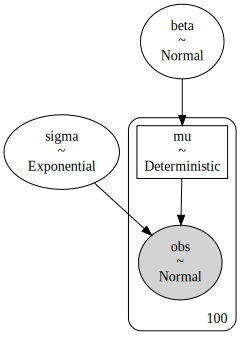

In [4]:
pm.model_to_graphviz(no_data_model)

In [ ]:
idata.observed_data

In [ ]:
with pm.Model() as no_data_model:
    x_data = pm.ConstantData("x_data", x)
    y_data = pm.ConstantData("y_data", y)
    beta = pm.Normal("beta")
    mu = pm.Deterministic("mu", beta * x_data)
    sigma = pm.Exponential("sigma", 1)
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=y_data)
    idata = pm.sample(random_seed=RANDOM_SEED)

In [ ]:
pm.model_to_graphviz(no_data_model)

In [ ]:
idata.constant_data

In [ ]:
df_data = pd.DataFrame(columns=["date"]).set_index("date")
dates = pd.date_range(start="2020-05-01", end="2020-07-01")

for city, mu in {"Berlin": 15, "San Marino": 18, "Paris": 16}.items():
    df_data[city] = rng.normal(loc=mu, size=len(dates))

df_data.index = dates
df_data.index.name = "date"
df_data.head()

In [ ]:
# The data has two dimensions: date and city
# The "coordinates" are the unique values that these dimensions can take
coords = {"date": df_data.index, "city": df_data.columns}

In [ ]:
with pm.Model(coords=coords) as model:
    data = pm.ConstantData("observed_temp", df_data, dims=("date", "city"))

    europe_mean = pm.Normal("europe_mean_temp", mu=15.0, sigma=3.0)
    city_offset = pm.Normal("city_offset", mu=0.0, sigma=3.0, dims="city")
    city_temperature = pm.Deterministic(
        "expected_city_temp", europe_mean + city_offset, dims="city"
    )

    sigma = pm.Exponential("sigma", 1)
    pm.Normal("temperature", mu=city_temperature, sigma=sigma, observed=data, dims=("date", "city"))

    idata = pm.sample(
        random_seed=RANDOM_SEED,
    )

In [ ]:
pm.model_to_graphviz(model)

In [ ]:
for k, v in model.coords.items():
    print(f"{k}: {v[:20]}")

In [ ]:
idata.posterior.coords

In [ ]:
axes = az.plot_trace(idata, var_names=["europe_mean_temp", "expected_city_temp"], legend=True);

In [ ]:
type(data)

In [ ]:
data = pm.ConstantData("observed_temp", df_data, dims=("date", "city"))

In [ ]:
model["observed_temp"].eval()[:15]

# Mutable Data

In [16]:
# We generate 10 datasets
n_models = 10
obs_multiplier = 10

true_mu = [rng.random() for _ in range(n_models)]
observed_data = [mu + rng.normal(size=(i + 1) * obs_multiplier) for i, mu in enumerate(true_mu)]

with pm.Model() as model:
    data = pm.MutableData("data", observed_data[0])
    mu = pm.Normal("mu", 0, 10)
    pm.Normal("y", mu=mu, sigma=1, observed=data)
    idata2 = pm.sample()

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━  86% 0:00:01

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

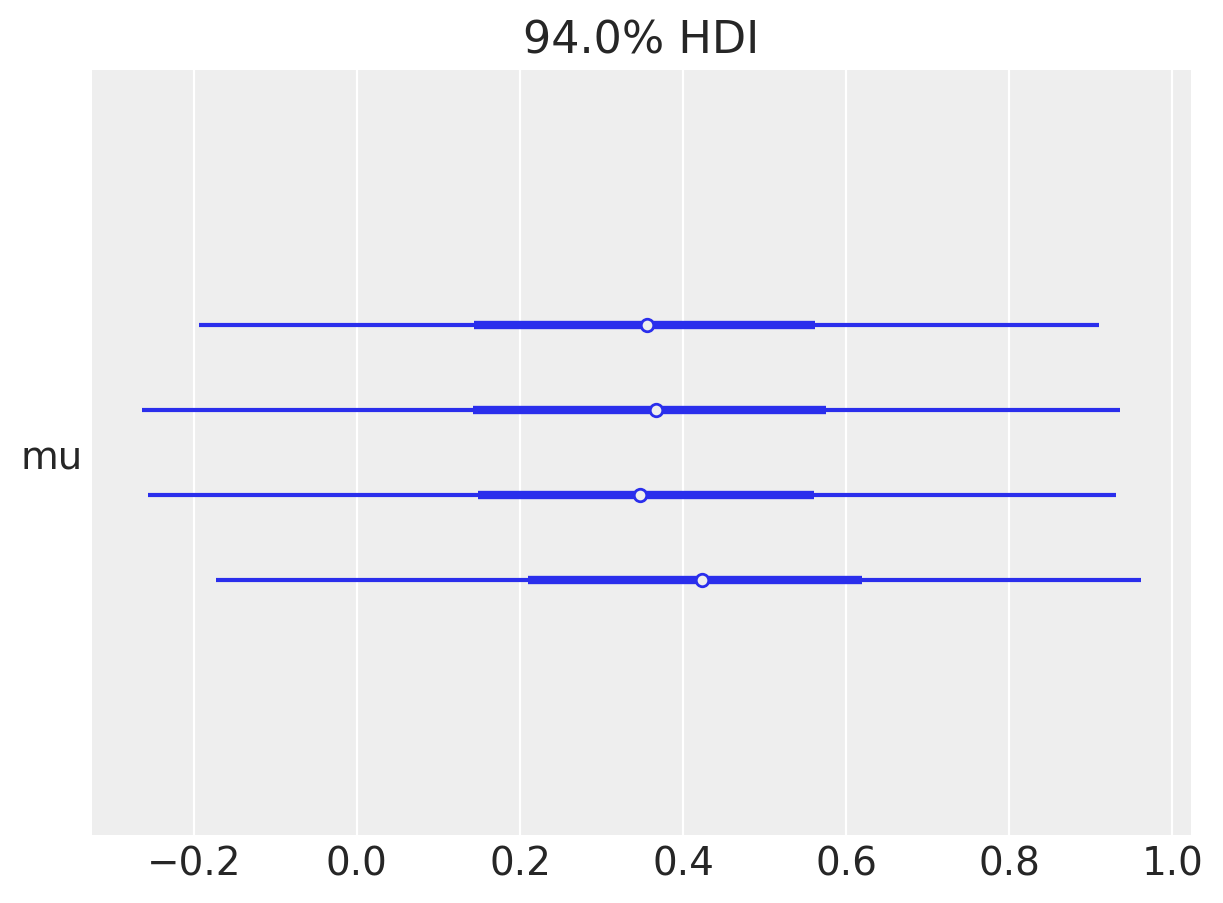

In [20]:
az.plot_forest(idata2, var_names=["mu"])

In [23]:
# Generate one trace for each dataset
idata_test = []
for data_vals in [observed_data[1]]:
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        idata_test.append(pm.sample_posterior_predictive(idata2, random_seed=RANDOM_SEED))

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

In [27]:
idata_test[0]['posterior_predictive']

<xarray.Dataset> Size: 648kB
Dimensions:  (chain: 4, draw: 1000, y_dim_2: 20)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * y_dim_2  (y_dim_2) int64 160B 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
Data variables:
    y        (chain, draw, y_dim_2) float64 640kB 0.4161 3.215 ... -0.3011
Attributes:
    created_at:                 2024-05-12T14:33:38.428790+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.13.0

In [24]:
az.plot_forest(idata_test, var_names=["mu"])

ValueError: Can not extract posterior from Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data! See /Users/mori/anaconda3/envs/BayesianInference/lib/python3.10/site-packages/arviz/data/converters.py for other conversion utilities.

In [14]:
observed_data[1].shape

(20,)

In [6]:
type(model["data"])

pytensor.tensor.sharedvar.TensorSharedVariable

In [7]:
model["data"].eval()

array([-0.26156104, -0.32064537, -0.36702704, -0.55700426,  0.91579879,
        0.80211268,  1.800818  ,  0.67411555,  1.11021628, -0.97339392])

In [8]:
# Generate one trace for each dataset
idatas = []
for data_vals in observed_data:
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        idatas.append(pm.sample(random_seed=RANDOM_SEED))

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━  84% 0:00:01

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [10]:
idatas

[Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data
 	> constant_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data
 	> constant_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data
 	> constant_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data
 	> constant_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data
 	> constant_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data
 	> constant_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data
 	> constant_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data
 	> constant_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data
 	> constant_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data
 	> constant_data]

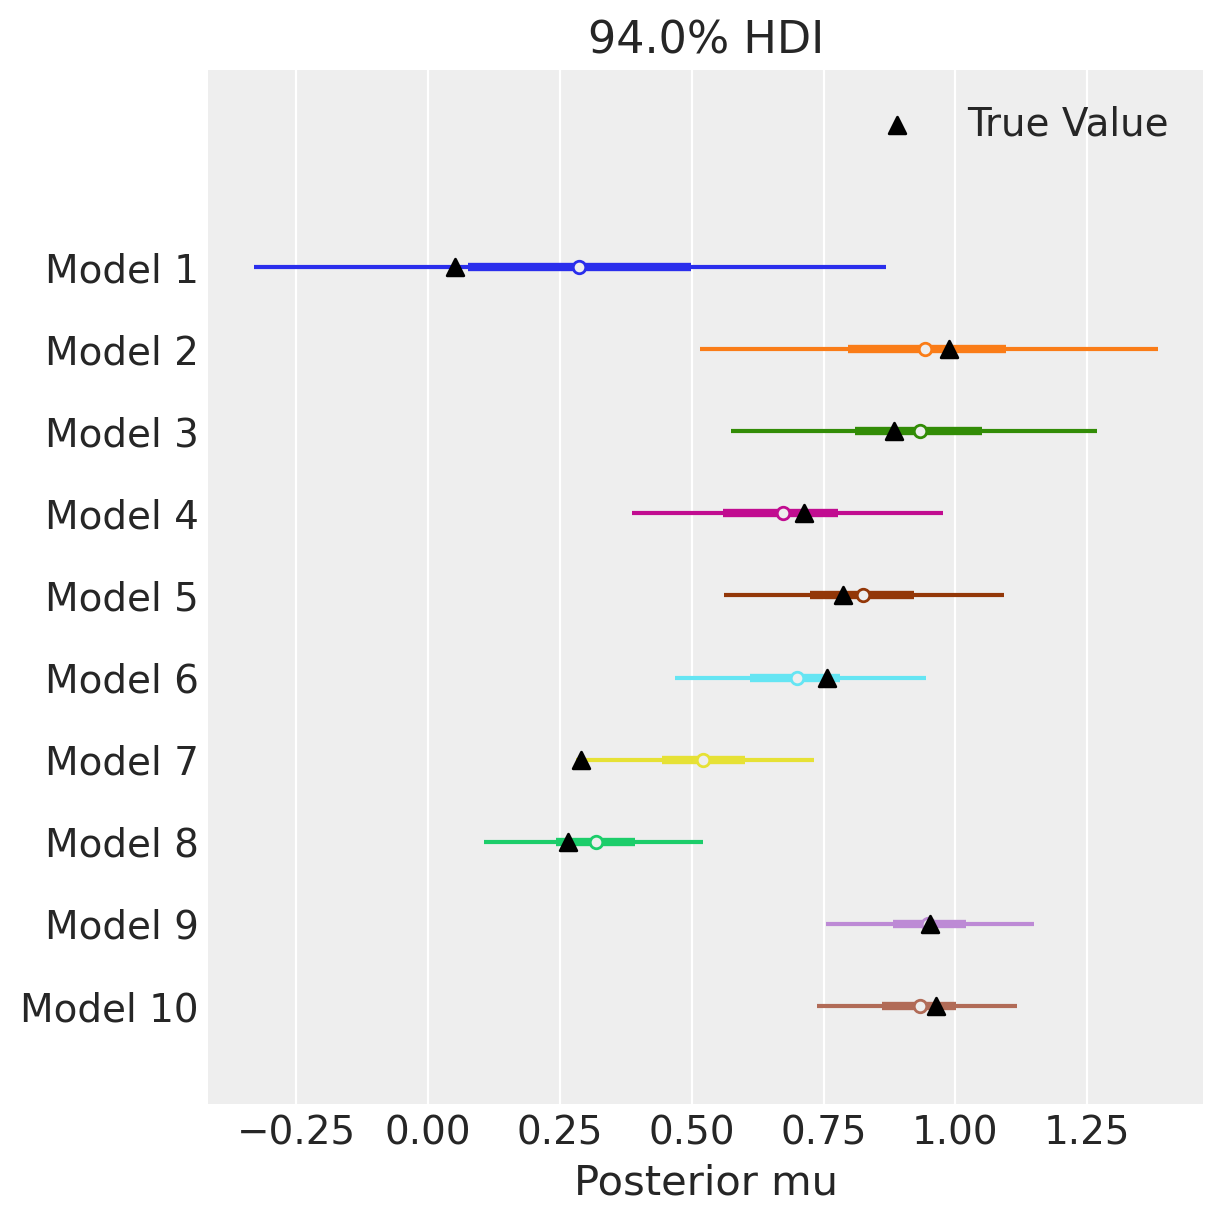

In [9]:
model_idx = np.arange(n_models, dtype="int")
axes = az.plot_forest(idatas, var_names=["mu"], combined=True, figsize=(6, 6), legend=False)

ax = axes[0]
y_vals = np.stack([ax.get_lines()[i].get_ydata() for i in np.arange(n_models)]).ravel()
ax.scatter(true_mu, y_vals[::-1], marker="^", color="k", zorder=100, label="True Value")
ax.set(yticklabels=[f"Model {i+1}" for i in model_idx[::-1]], xlabel="Posterior mu")
ax.legend()
plt.show()

## Example: PREDICTION with X and Y variables

In [28]:
n_obs = 100
true_beta = 1.5
true_alpha = 0.25

x = rng.normal(size=n_obs)
true_p = 1 / (1 + np.exp(-(true_alpha + true_beta * x)))
y = rng.binomial(n=1, p=true_p)

In [61]:
with pm.Model() as logistic_model:
    x_data = pm.Data("x", x)
    y_data = pm.Data("y", y)

    alpha = pm.Normal("alpha") # N(0, 1)
    beta = pm.Normal("beta")

    p = pm.Deterministic("p", pm.math.sigmoid(alpha + beta * x_data))

    # Here is were we link the shapes of the inputs (x_data) and the observed varaiable
    # It will be the shape we tell it, rather than the (constant!) shape of y_data
    obs = pm.Bernoulli("obs", p=p, observed=y_data, shape=x_data.shape[0])
    # fit the model
    idata = pm.sample(random_seed=RANDOM_SEED)

    # Generate a counterfactual dataset using our model
    idata = pm.sample_posterior_predictive(
        idata, extend_inferencedata=True, random_seed=RANDOM_SEED
    )

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

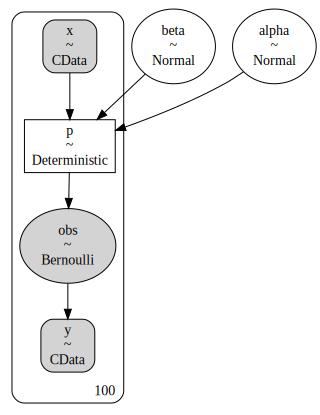

In [59]:
pm.model_to_graphviz(logistic_model)

In [62]:
grid_size = 250
x_grid = np.linspace(x.min(), x.max(), grid_size)
with logistic_model:
    # Switch out the observations and use `sample_posterior_predictive` to predict
    # We do not need to set data for the outputs because we told the model to always link the shape of the output to the shape
    # of the input.
    pm.set_data({"x": x_grid})
    post_idata = pm.sample_posterior_predictive(
        idata, var_names=["p", "obs"], random_seed=RANDOM_SEED
    )

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

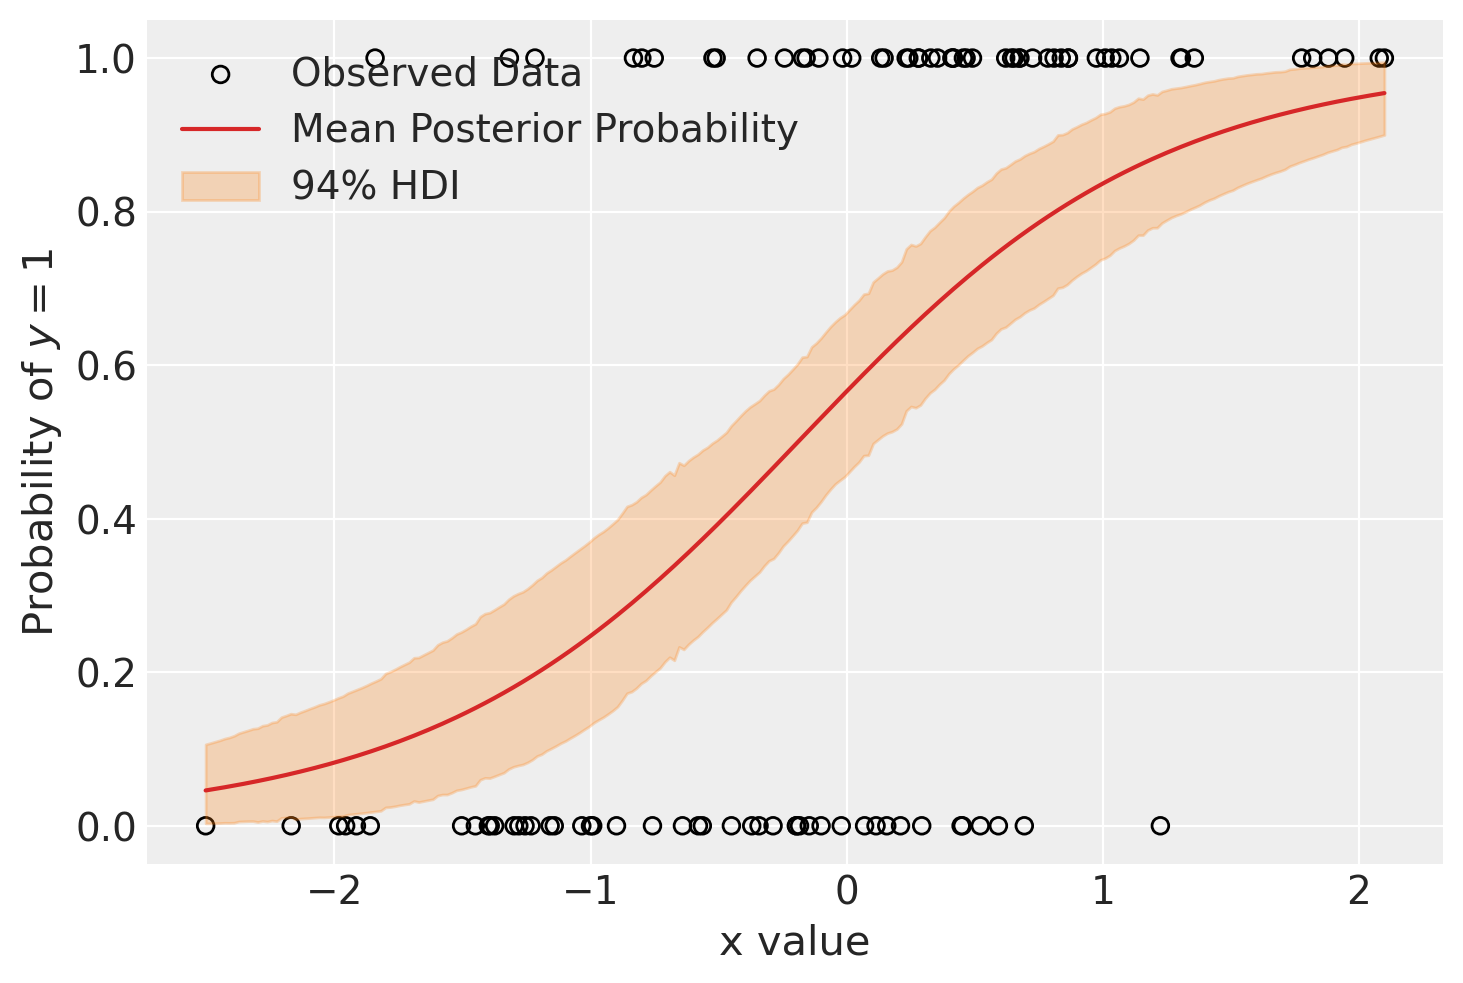

In [63]:
fig, ax = plt.subplots()
hdi = az.hdi(post_idata.posterior_predictive.p).p

ax.scatter(x, y, facecolor="none", edgecolor="k", label="Observed Data")
p_mean = post_idata.posterior_predictive.p.mean(dim=["chain", "draw"])
ax.plot(x_grid, p_mean, color="tab:red", label="Mean Posterior Probability")
ax.fill_between(x_grid, *hdi.values.T, color="tab:orange", alpha=0.25, label="94% HDI")
ax.legend()
ax.set(ylabel="Probability of $y=1$", xlabel="x value")
plt.show()

## Example2

In [ ]:
try:
    data = pd.read_csv("../data/babies.csv")
except FileNotFoundError:
    data = pd.read_csv(pm.get_data("babies.csv"))
data.plot.scatter("Month", "Length", alpha=0.4);

In [ ]:
with pm.Model(
    coords_mutable={"obs_idx": np.arange(len(data))}, coords={"parameter": ["intercept", "slope"]}
) as model_babies:
    mean_params = pm.Normal("mean_params", sigma=10, dims=["parameter"])
    sigma_params = pm.Normal("sigma_params", sigma=10, dims=["parameter"])
    month = pm.MutableData("month", data.Month.values.astype(float), dims=["obs_idx"])

    mu = pm.Deterministic("mu", mean_params[0] + mean_params[1] * month**0.5, dims=["obs_idx"])
    sigma = pm.Deterministic("sigma", sigma_params[0] + sigma_params[1] * month, dims=["obs_idx"])

    length = pm.Normal("length", mu=mu, sigma=sigma, observed=data.Length, dims=["obs_idx"])

    idata_babies = pm.sample(random_seed=RANDOM_SEED)

In [ ]:
with model_babies:
    pm.sample_posterior_predictive(idata_babies, extend_inferencedata=True, random_seed=RANDOM_SEED)

In [ ]:
ax = az.plot_hdi(
    data.Month,
    idata_babies.posterior_predictive["length"],
    hdi_prob=0.6,
    fill_kwargs={"alpha": 0.8},
)
ax.plot(
    data.Month,
    idata_babies.posterior["mu"].mean(("chain", "draw")),
    label="Posterior predictive mean",
)
ax = az.plot_lm(
    idata=idata_babies,
    y="length",
    x="month",
    kind_pp="hdi",
    y_kwargs={"color": "k", "ms": 6, "alpha": 0.15},
    y_hat_fill_kwargs=dict(fill_kwargs={"alpha": 0.4}),
    axes=ax,
)

In [ ]:
ages_to_check = [0.5]
with model_babies:
    pm.set_data({"month": ages_to_check}, coords={"obs_idx": [0]})

    # Setting predictions=True will add a new "predictions" group to our idata. This lets us store the posterior,
    # posterior_predictive, and predictions all in the same object.
    idata_babies = pm.sample_posterior_predictive(
        idata_babies, extend_inferencedata=True, predictions=True, random_seed=RANDOM_SEED
    )

In [ ]:
ref_length = 51.5

az.plot_posterior(
    idata_babies,
    group="predictions",
    ref_val={"length": [{"ref_val": ref_length}]},
    labeller=az.labels.DimCoordLabeller(),
);